In this analysis, we will explore a dataset of google job ads. Those ads correspond either to the search string `machine learning engineer` or `data scientist`.

In [1]:
import os
import io
import re
import yaml

import pandas as pd
import numpy as np

from stemming import porter2

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import cross_validate, GridSearchCV, learning_curve
from sklearn.compose import ColumnTransformer
from sklearn import set_config


import matplotlib as mlib
import matplotlib.pyplot as plt
import seaborn as sns

from google.cloud import storage

In [2]:
set_config(display='diagram')

In [3]:
config_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'config.yaml'))
with open(config_path, 'r') as config_file:
    config = yaml.load(config_file, Loader=yaml.SafeLoader)

In [4]:
%matplotlib inline

In [38]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.dpi'] = 180
plt.rcParams['figure.figsize'] = (8, 4)

In [6]:
client = storage.Client(config['project'])
bucket = client.get_bucket(config['bucket'])
blob = bucket.blob(config['dest_file'])
file_content = io.BytesIO(blob.download_as_string())

ads = pd.read_csv(file_content)

/Users/ruslan.kozhuharov/venvs/tf/lib/python3.7/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [7]:
ads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581 entries, 0 to 580
Data columns (total 7 columns):
id                  581 non-null object
job_descr           578 non-null object
location            552 non-null object
minimum_qual        578 non-null object
preferred_qual      578 non-null object
responsibilities    578 non-null object
title               581 non-null object
dtypes: object(7)
memory usage: 31.9+ KB


First, let us try using simple string operations to derive the additional information from the job title. Such information could be: seniority, function, etc.

In [8]:
ads.fillna('unknown', inplace=True)

In [9]:
def split_title(df):
    df[['role', 'department', 'area', 'other']] = df.title.str.split(',', expand=True)
    return df


def get_seniority(df):
    seniority_re = r'.*(intern|senior|lead|staff|principal|manager|head).*'
    seniority_normal = 'l3-l4'
    seniority_mapping = {'intern': 1,
                         seniority_normal: 3,
                         'senior': 5,
                         'lead': 6,
                         'staff': 7,
                         'principal': 8,
                         'manager': 9,
                         'head': 10}
    
    df['seniority'] = df.role.str.extract(pat=seniority_re, flags=re.I).fillna(seniority_normal)[0].str.lower()
    df['seniority_rank'] = df.seniority.map(seniority_mapping)
    return df


def get_function(df):
    function_re = r'.*(engineer|scientist|science|consultant|architect|advocate|developer|analyst|specialist).*'
    df['function'] = (df.role.str.extract(pat=function_re, flags=re.I)[0]
                      .str.lower().str.replace('science', 'scientist', flags=re.I))
    return df

In [10]:
ads = split_title(ads)
ads = get_seniority(ads)
ads = get_function(ads)

In [11]:
ads[['title', 'role', 'department', 'area', 'seniority', 'seniority_rank', 'function']].head()

,title,role,department,area,seniority,seniority_rank,function
0,"Cloud AI Engineer, Professional Services",Cloud AI Engineer,Professional Services,None,l3-l4,3,engineer
1,"Cloud AI Engineer, Professional Services",Cloud AI Engineer,Professional Services,None,l3-l4,3,engineer
2,"Conversational AI Engineer, Google Cloud Profe...",Conversational AI Engineer,Google Cloud Professional Services,None,l3-l4,3,engineer
3,"Cloud AI Engineer, Professional Services",Cloud AI Engineer,Professional Services,None,l3-l4,3,engineer
4,"Data Scientist, Engineering",Data Scientist,Engineering,None,l3-l4,3,scientist


An interesting insight could be to see the most relevant terms from the qualifications and responsibilities with regards to the function. This could give us an isight into the keywords that one should emphasize on in their resume.

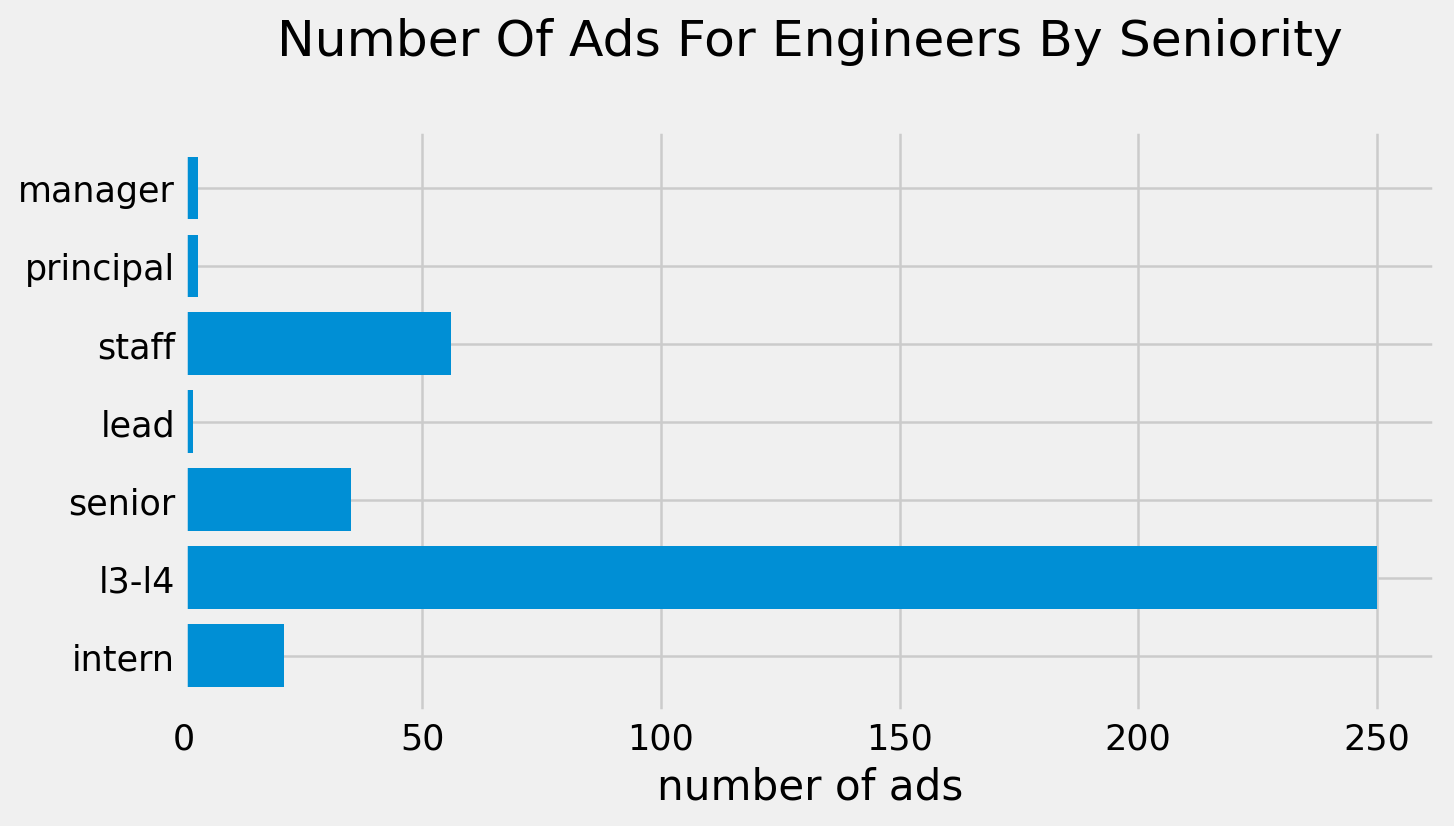

In [39]:
to_plot = (ads[ads.function=='engineer']
           .groupby(['seniority', 'seniority_rank'])
           .id.nunique().sort_index(level=1))

plt.barh(to_plot.index.get_level_values('seniority'), to_plot.values)
plt.xlabel('number of ads')
plt.title('Number Of Ads For Engineers By Seniority', pad=30)
plt.show()

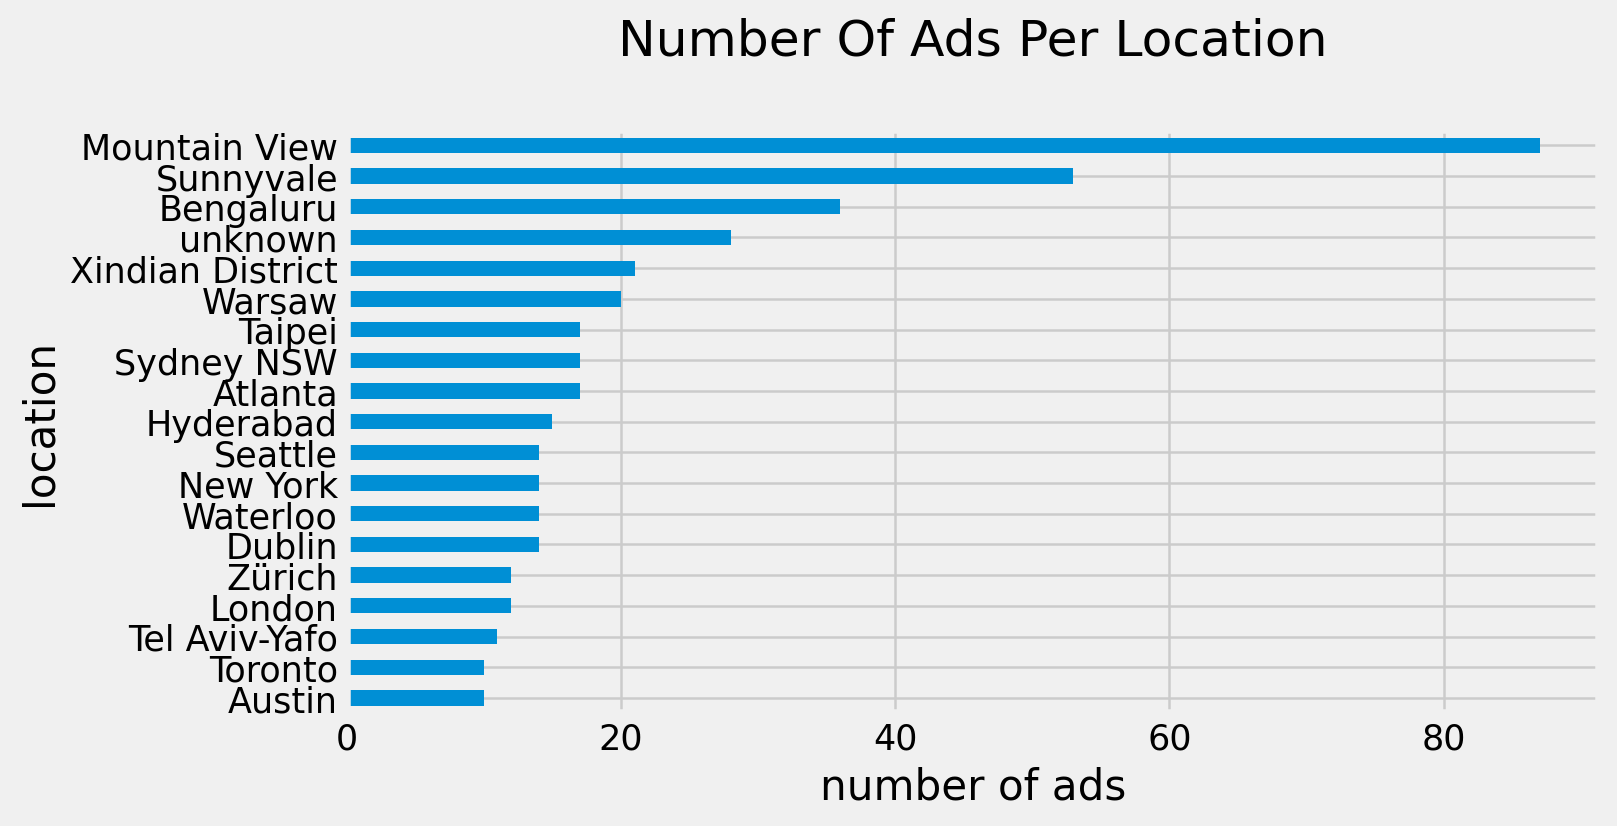

In [40]:
to_plot = ads.groupby('location').id.nunique()
to_plot[to_plot>=10].sort_values().plot.barh()
plt.xlabel('number of ads')
plt.title('Number Of Ads Per Location', pad=30)
plt.show()

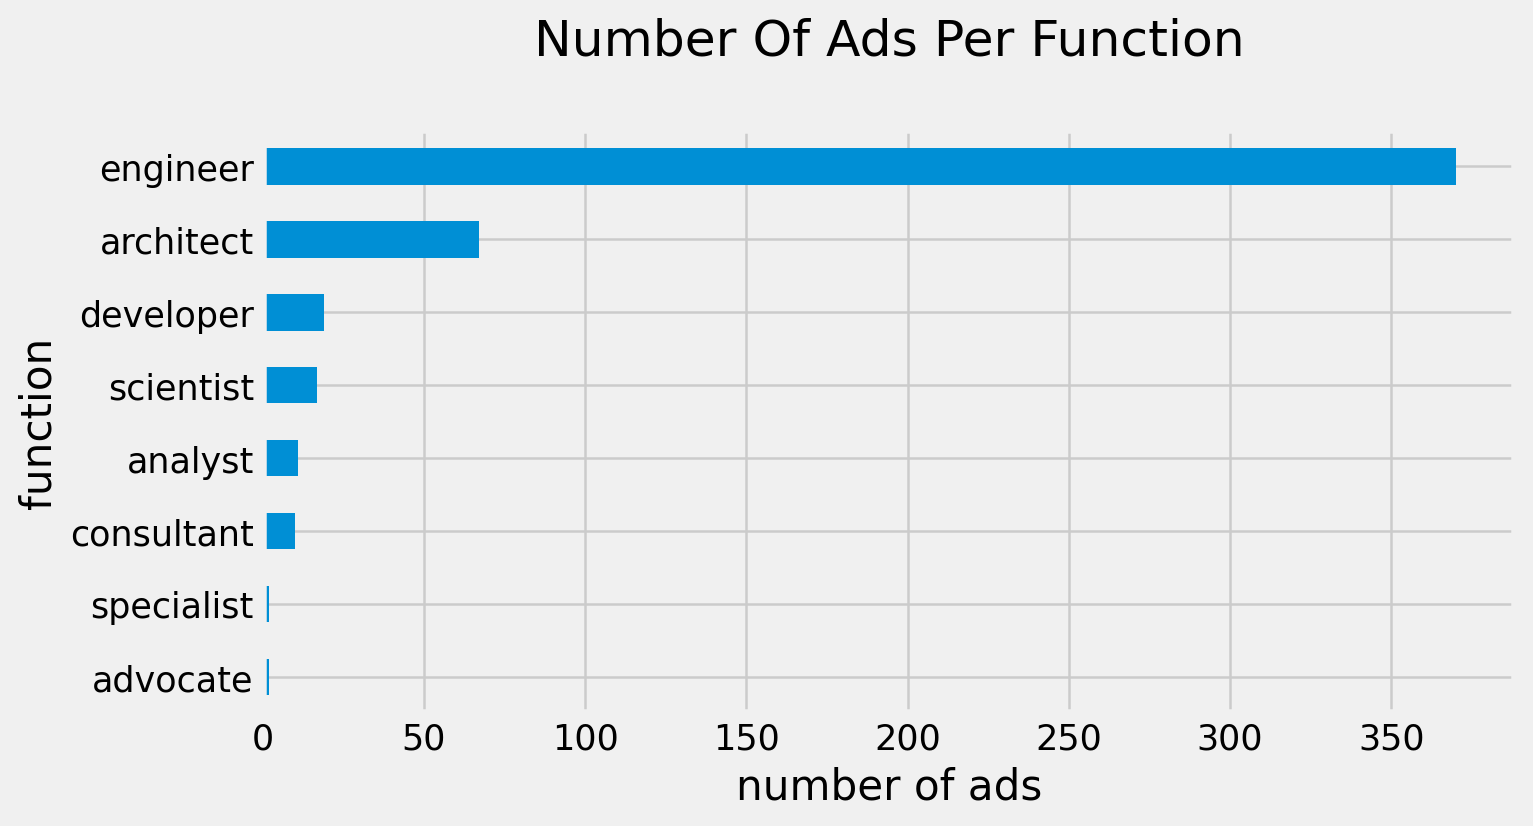

In [41]:
to_plot = ads.groupby('function').id.nunique()
to_plot.sort_values().plot.barh()
plt.xlabel('number of ads')
plt.title('Number Of Ads Per Function', pad=30)
plt.show()

In [15]:
to_model = ads[ads.function.isin(['engineer', 'scientist', 'architect'])].copy()

In [16]:
label_enc = LabelEncoder()
to_model['function_enc'] = label_enc.fit_transform(to_model.function.astype('str'))

In [17]:
tfidf_params = {'stop_words':'english',
                'ngram_range':(2, 5),
                'strip_accents':'unicode'}

text_cols = ['job_descr', 'minimum_qual', 'preferred_qual', 'responsibilities']

column_trans = ColumnTransformer([(f'tfidf_{c}', TfidfVectorizer(**tfidf_params), c) for c in text_cols])

multi_col_pipe = Pipeline([('multi_col_tfidf', column_trans),
                           ('naive_bayes_clf', MultinomialNB())])

In [18]:
X = to_model.drop('function_enc', axis=1)
y = to_model.function_enc

In [19]:
model = multi_col_pipe.fit(X, y)

In [20]:
model

Pipeline(steps=[('multi_col_tfidf',
                 ColumnTransformer(transformers=[('tfidf_job_descr',
                                                  TfidfVectorizer(ngram_range=(2,
                                                                               5),
                                                                  stop_words='english',
                                                                  strip_accents='unicode'),
                                                  'job_descr'),
                                                 ('tfidf_minimum_qual',
                                                  TfidfVectorizer(ngram_range=(2,
                                                                               5),
                                                                  stop_words='english',
                                                                  strip_accents='unicode'),
                                                  'minimum_qual'),
                                                 ('tfidf_preferred_qual',
                                                  TfidfVectorizer(ngram_range=(2,
                                                                               5),
                                                                  stop_words='english',
                                                                  strip_accents='unicode'),
                                                  'preferred_qual'),
                                                 ('tfidf_responsibilities',
                                                  TfidfVectorizer(ngram_range=(2,
                                                                               5),
                                                                  stop_words='english',
                                                                  strip_accents='unicode'),
                                                  'responsibilities')])),
                ('naive_bayes_clf', MultinomialNB())])

In [21]:
scores = cross_validate(model, X, y, cv=3, scoring='f1_weighted', return_train_score=True)

In [22]:
for k in scores.keys():
    print(f'{k}, mean: {scores[k].mean():.2f}, std: {scores[k].std():.2f}')

fit_time, mean: 0.61, std: 0.04
score_time, mean: 0.19, std: 0.03
test_score, mean: 0.88, std: 0.02
train_score, mean: 0.98, std: 0.00


In [23]:
steps = 100

lc_res = learning_curve(model, X, y, cv=3, train_sizes=np.linspace(0.1, 1.0, steps), scoring='f1_weighted', n_jobs=6, random_state=42)

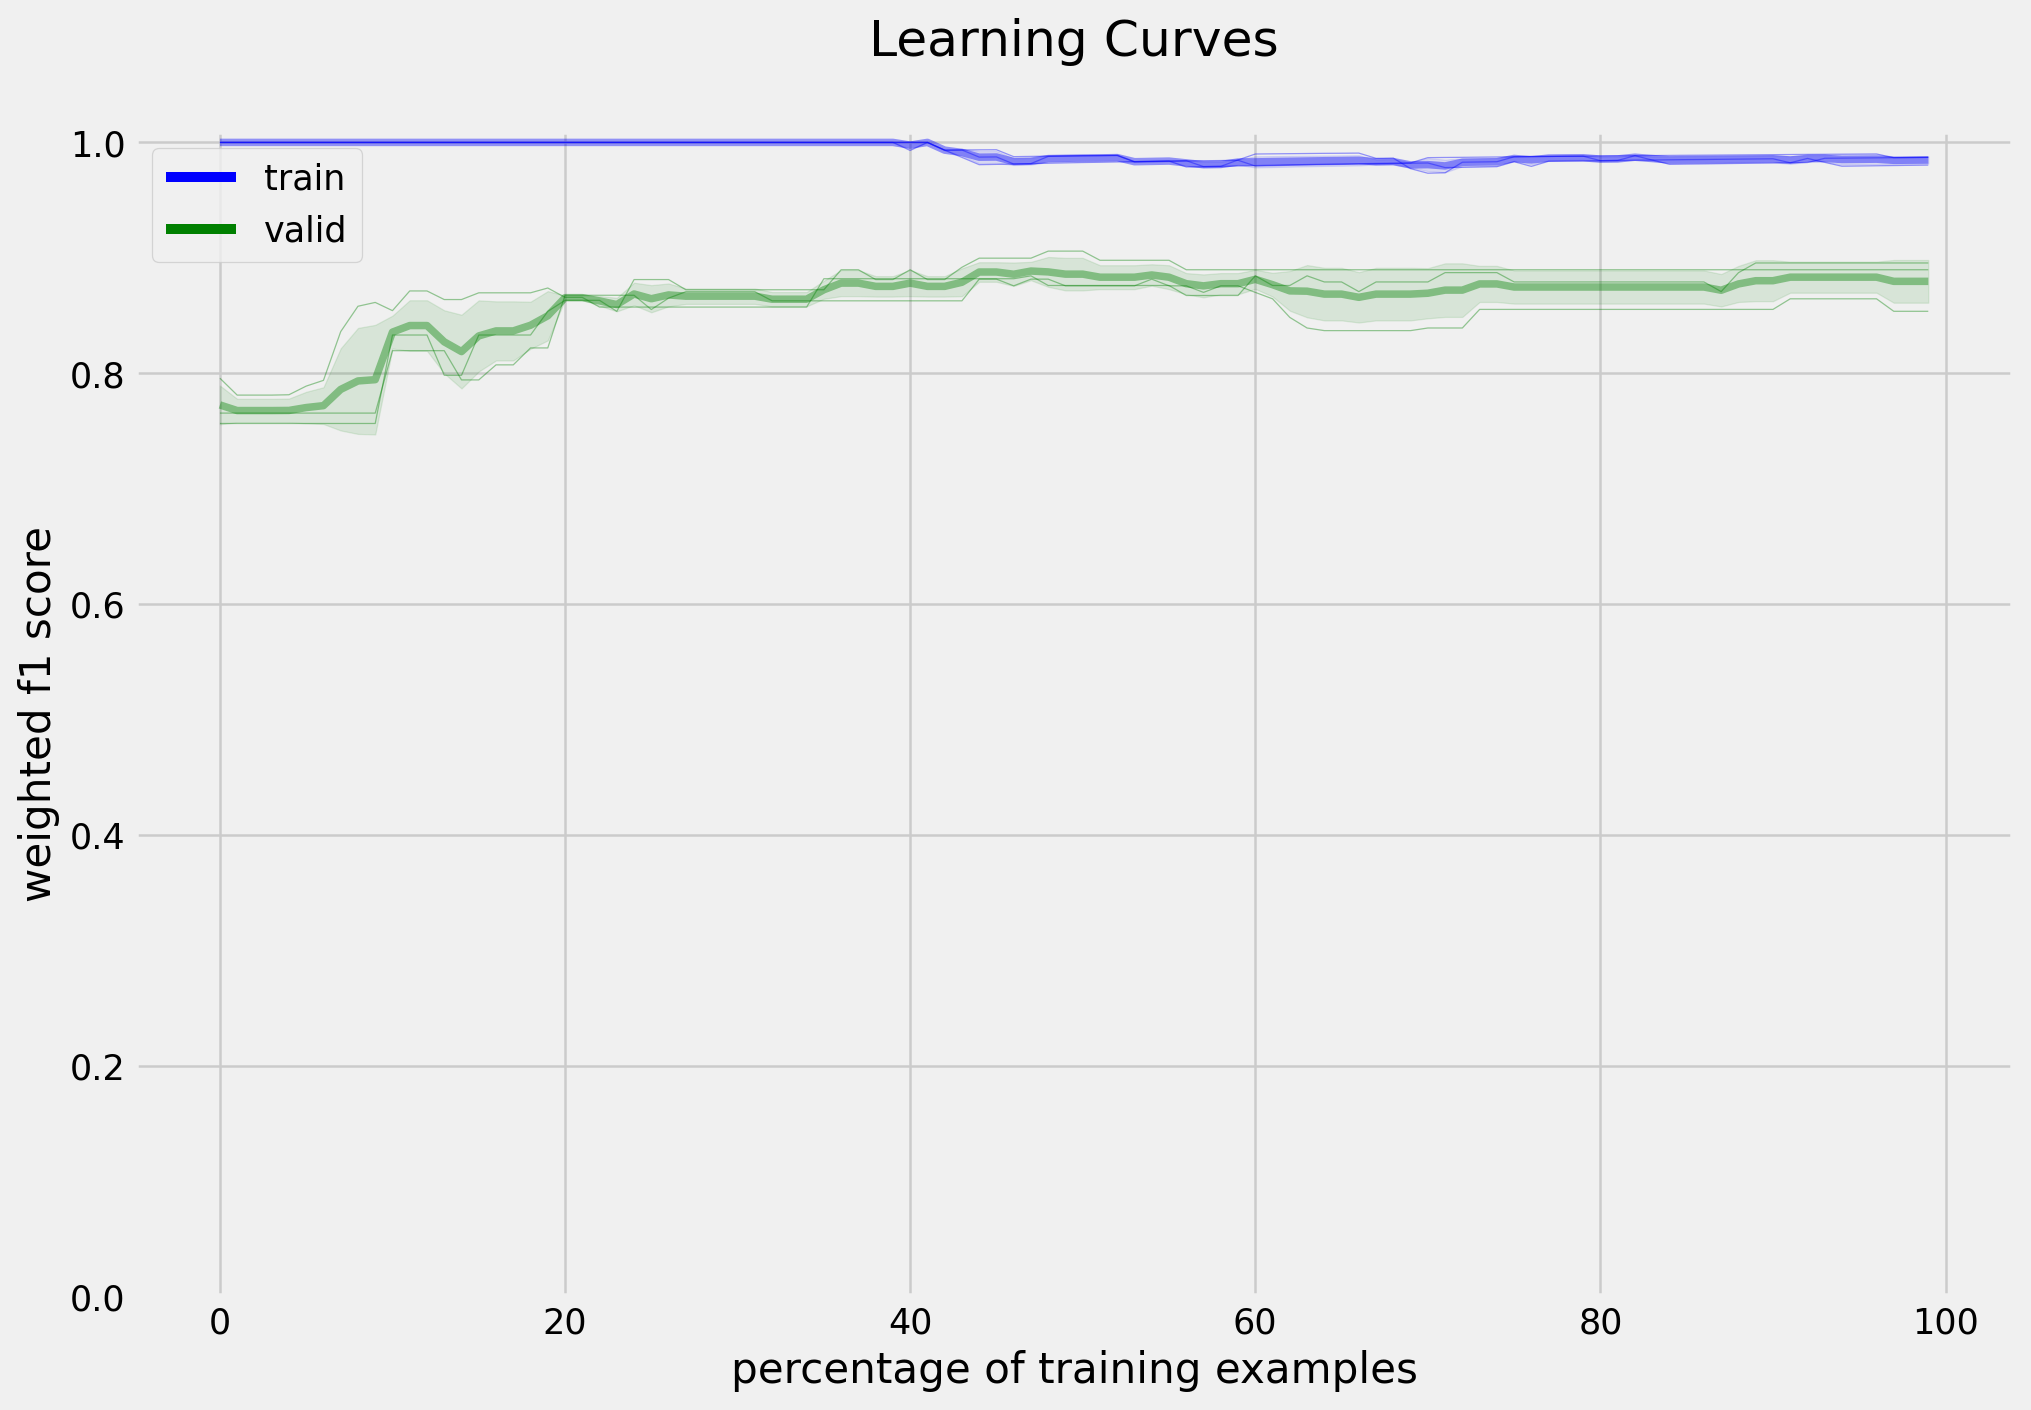

In [42]:
fig=plt.figure(figsize=(12, 8))

legend_handles = []

for i, c, l in zip([1, 2], ['b', 'g'], ['train', 'valid']):
    scores = lc_res[i]
    mean = np.mean(scores, axis=1)
    std = np.std(scores, axis=1)
    
    plt.fill_between(range(0, steps), mean-std, mean+std, color=c, alpha=0.1)
    plt.plot(mean, c=c, linewidth=3, alpha=0.4)
    legend_handles.append(mlib.lines.Line2D([], [], color=c, label=l))
    
    for j in range(3):
        plt.plot(scores[:, j], c=c, linewidth=0.5, alpha=0.4)

plt.ylim(0, 1.01)
plt.legend(handles=legend_handles)
plt.ylabel('weighted f1 score')
plt.xlabel('percentage of training examples')
plt.title('Learning Curves', pad=30)
plt.show()

In [25]:
importances_mcp = pd.DataFrame(model['naive_bayes_clf'].feature_log_prob_.transpose(),
                               columns=label_enc.classes_,
                               index=model['multi_col_tfidf'].get_feature_names())

In [26]:
col_prefix = re.compile('(' + '|'.join([f'tfidf_{c}' for c in text_cols]) + ')(__)(.*)')

In [27]:
top_n = 50
imp_terms = pd.DataFrame()

for l in label_enc.classes_:
    imp_label = importances_mcp[l].sort_values(ascending=False)[:top_n]
    to_append = [{'feature': col_prefix.match(feature_term)[1],
                  'term': col_prefix.match(feature_term)[3],
                  'importance': imp,
                  'label': l}
                 for feature_term, imp in zip(imp_label.index, imp_label.values)]
    imp_terms = imp_terms.append(to_append, ignore_index=True)

In [28]:
imp_terms.sort_values('importance').head()

,feature,term,importance,label
149,tfidf_minimum_qual,quantitative discipline statistics bioinformatics,-11.632890,scientist
148,tfidf_minimum_qual,statistics bioinformatics,-11.632890,scientist
147,tfidf_preferred_qual,publication record,-11.631756,scientist
145,tfidf_minimum_qual,equivalent practical experience experience,-11.624941,scientist
146,tfidf_minimum_qual,practical experience experience,-11.624941,scientist


In [29]:
to_crosstab = imp_terms[imp_terms.label=='scientist']

pd.crosstab(to_crosstab.term, to_crosstab.feature).head()

feature,tfidf_job_descr,tfidf_minimum_qual,tfidf_preferred_qual
term,,,
data analysis,0,1,1
data scientist,0,1,0
database languages,0,1,0
degree quantitative,0,1,0
degree quantitative discipline,0,1,0
